In [1]:
import numpy as np
import matplotlib.pyplot as plt
from epymorph.simulation import Context
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.geography.us_census import StateScope
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.time import ByEpiWeek
from epymorph.adrio.cdc import InfluenzaStateHospitalization
from epymorph.forecasting.dynamic_params import GaussianPrior, OrnsteinUhlenbeck
from epymorph.forecasting.pipeline import (
    FromOutput,
    UnknownParam,
)
from epymorph.forecasting.pipeline import (
    ForecastSimulator,
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
)
from epymorph.adrio import acs5
from epymorph.forecasting.param_transformations import ExponentialTransform
from epymorph.geography.scope import GeoGrouping
import datetime
from epymorph.time import date
from epymorph.attribute import NamePattern


class ByNode(GeoGrouping):
    def map(self, node_ids):
        return node_ids.copy()


class NoGrouping(GeoGrouping):
    def __init__(self, group_name="all"):
        self.group_name = "all"

    def map(self, node_ids):
        return np.broadcast_to(np.array([self.group_name]), node_ids.shape)


def interval_score(alpha, lower, upper, y):
    return (
        upper
        - lower
        + alpha / 2 * (lower - y) * (y < lower)
        + alpha / 2 * (y - upper) * (y > upper)
    )


def weighted_interval_score(quantiles, quantile_values, y):
    K = int((quantiles.shape[0] - 1) / 2)
    score = 0
    for k in range(K):
        alpha_k = quantiles[-(k + 1)] - quantiles[k]
        score = score + alpha_k / 2 * interval_score(
            alpha_k, quantile_values[k], quantile_values[-(k + 1)], y
        )

    m = quantile_values[K + 1]
    score = score + 1 / 2 * np.abs(y - m)
    return score / (K + 1 / 2)

In [2]:
from epymorph.forecasting.dynamic_params import BrownianMotion, UniformPrior


my_rng = np.random.default_rng(1)

num_realizations = 100

# 2023-2024 Season
flusight_start_date = "2023-10-08"  # The Sunday of the first epiweek to forecast.
flusight_weeks = 30
burn_in_weeks = 20
warm_up_weeks = 10
forecast_horizon = 3

assert date.fromisoformat(flusight_start_date).weekday() == 6

simulation_start_date = (
    date.fromisoformat(flusight_start_date)
    + datetime.timedelta(days=-7 * burn_in_weeks)
    + datetime.timedelta(days=-7 * warm_up_weeks)
)
warm_up_time_frame = TimeFrame.of(
    simulation_start_date, duration_days=warm_up_weeks * 7
)

my_scope = StateScope.in_states(["AZ", "CO", "NM", "UT"], year=2015)
# my_scope = StateScope.all(year=2015)

my_rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=my_scope,
    init=Proportional(
        ratios=np.broadcast_to(
            np.array([500, 1, 100, 0], dtype=np.int64), shape=(my_scope.nodes, 4)
        )
    ),
    # The time frame for the first stage in the pipeline: the warm up.
    time_frame=warm_up_time_frame,
    params={
        "beta": ExponentialTransform("log_beta"),
        "gamma": 1 / 5,
        "xi": 1 / 90,
        # "hospitalization_prob": 300 / 100_000,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

log_beta_damping = 1 / 21
log_beta_mean = np.log(0.23)
log_beta_standard_deviation = 0.2

# my_unknown_params = {
#     "log_beta": UnknownParam(
#         prior=GaussianPrior(
#             mean=log_beta_mean,
#             standard_deviation=log_beta_standard_deviation,
#         ),
#         dynamics=OrnsteinUhlenbeck(
#             damping=log_beta_damping,
#             mean=log_beta_mean,
#             standard_deviation=log_beta_standard_deviation,
#         ),
#     ),
# }

my_unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=log_beta_damping,
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
    ),
    "hospitalization_prob": UnknownParam(
        prior=UniformPrior(lower=100 / 100_000, upper=500 / 100_000),
        # dynamics=Static(),
        dynamics=BrownianMotion(voliatility=1 / 100_000),
    ),
}

my_observations = Observations(
    source=InfluenzaStateHospitalization(),
    model_link=ModelLink(
        geo=my_rume.scope.select.all(),
        time=my_rume.time_frame.select.all().group(ByEpiWeek()).agg("sum"),
        quantity=my_rume.ipm.select.events("I->H"),
    ),
    likelihood=Poisson(),
)


In [3]:
save_quantiles = np.array(
    [
        0.01,
        0.025,
        0.05,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.35,
        0.4,
        0.45,
        0.5,
        0.55,
        0.6,
        0.65,
        0.7,
        0.75,
        0.8,
        0.85,
        0.9,
        0.95,
        0.975,
        0.99,
    ]
)

In [4]:
print(f"Warm up without observations for {warm_up_weeks} weeks:")
warm_up_simulator = ForecastSimulator(
    config=FromRUME(
        rume=my_rume,
        num_realizations=num_realizations,
        unknown_params=my_unknown_params,
    ),
    save_trajectories=False,
)
warm_up_output = warm_up_simulator.run(rng=my_rng)

print(f"Burn in with observations for {burn_in_weeks} weeks:")
burn_in_simulator = ParticleFilterSimulator(
    config=FromOutput(output=warm_up_output, extend_duration=burn_in_weeks * 7),
    observations=my_observations,
    save_trajectories=False,
)
burn_in_output = burn_in_simulator.run(rng=my_rng)


forecast_quantiles = []
forecast_total_quantiles = []
reference_dates = []

estimated_params = {NamePattern.of(k): [] for k in my_unknown_params.keys()}


print(f"Weekly {forecast_horizon}-week-ahead forecasts for {flusight_weeks} weeks:")
previous_output = burn_in_output
for i_week in range(flusight_weeks):
    print(f"Fit and forecast for week {i_week}:")
    particle_filter_simulator = ParticleFilterSimulator(
        config=FromOutput(output=previous_output, extend_duration=7),
        observations=my_observations,
        save_trajectories=False,
    )

    particle_filter_output = particle_filter_simulator.run(rng=my_rng)
    previous_output = particle_filter_output

    forecast_simulator = ForecastSimulator(
        config=FromOutput(
            output=particle_filter_output, extend_duration=7 * forecast_horizon
        )
    )
    forecast_output = forecast_simulator.run(rng=my_rng)

    # Save the samples from the posterior of the parameters.
    for k in estimated_params.keys():
        estimated_params[k].append(particle_filter_output.final_param_values[k])

    # Save the quantiles for each forecast, including the nowcast
    I_TO_H_INDEX = 1

    # The nowcast values require the *previous* week of hospitalizations, and so cannot
    # be calculated from the forecast output. Therefore we must treat them separately.
    nowcast_values = [particle_filter_output.posterior_values[0, ..., 0]]
    forecast_values = nowcast_values + [
        forecast_output.events[:, i * 7 : (i + 1) * 7, :, I_TO_H_INDEX].sum(axis=1)
        for i in range(3)
    ]

    # FluSight also wants the forecast for the whole US. Note we *cannot* take the sum
    # of the medians, we must take the sum first, then calculate the median.
    forecast_total_values = [values.sum(axis=1) for values in forecast_values]

    # Calculate and save the quantiles.
    forecast_quantiles.append(
        np.stack(
            [np.quantile(values, save_quantiles, axis=0) for values in forecast_values]
        )
    )
    forecast_total_quantiles.append(
        np.stack(
            [
                np.quantile(values, save_quantiles, axis=0)
                for values in forecast_total_values
            ]
        )
    )

    reference_dates.append(
        np.datetime64(particle_filter_output.rume.time_frame.end_date)
    )

for k in estimated_params.keys():
    estimated_params[k] = np.stack(estimated_params[k])

forecast_quantiles = np.stack(forecast_quantiles)
forecast_total_quantiles = np.stack(forecast_total_quantiles)
reference_dates = np.array(reference_dates)

Warm up without observations for 10 weeks:
Burn in with observations for 20 weeks:
Observation: 0, Label: 2023-21, Time Frame: 2023-05-21/2023-05-27 (7D)
Observation: 1, Label: 2023-22, Time Frame: 2023-05-28/2023-06-03 (7D)
Observation: 2, Label: 2023-23, Time Frame: 2023-06-04/2023-06-10 (7D)
Observation: 3, Label: 2023-24, Time Frame: 2023-06-11/2023-06-17 (7D)
Observation: 4, Label: 2023-25, Time Frame: 2023-06-18/2023-06-24 (7D)
Observation: 5, Label: 2023-26, Time Frame: 2023-06-25/2023-07-01 (7D)
Observation: 6, Label: 2023-27, Time Frame: 2023-07-02/2023-07-08 (7D)
Observation: 7, Label: 2023-28, Time Frame: 2023-07-09/2023-07-15 (7D)
Observation: 8, Label: 2023-29, Time Frame: 2023-07-16/2023-07-22 (7D)
Observation: 9, Label: 2023-30, Time Frame: 2023-07-23/2023-07-29 (7D)
Observation: 10, Label: 2023-31, Time Frame: 2023-07-30/2023-08-05 (7D)
Observation: 11, Label: 2023-32, Time Frame: 2023-08-06/2023-08-12 (7D)
Observation: 12, Label: 2023-33, Time Frame: 2023-08-13/2023-08

In [5]:
context = Context.of(
    scope=my_rume.scope,
    time_frame=TimeFrame.of(
        flusight_start_date, (flusight_weeks + forecast_horizon) * 7
    ),
    rng=my_rng,
)
real_data_result = (
    my_observations.source.with_context_internal(context).inspect().result
)
real_data = real_data_result["value"]
real_data_dates = real_data_result["date"][:, 0]


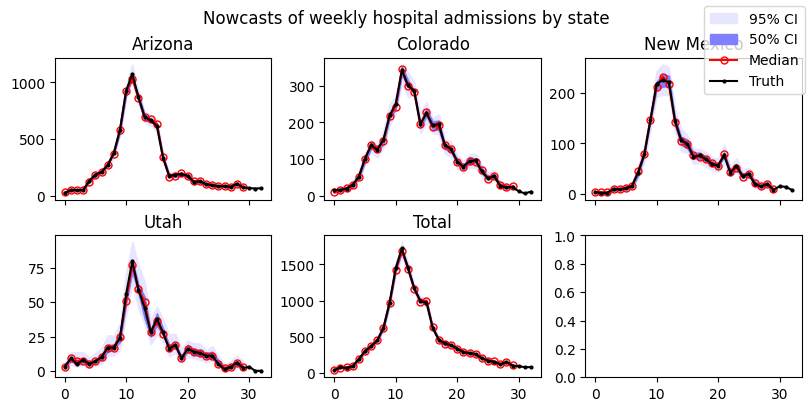

In [6]:
ncols = 3
nrows = int(np.ceil((my_rume.scope.nodes + 1) / ncols))
n_weeks_ahead = 0

# The index of the "total" node, which is not an actual node in the model.
total_node = my_rume.scope.nodes

LOWER_95_INDEX = 1
UPPER_95_INDEX = -2
LOWER_50_INDEX = 6
UPPER_50_INDEX = -7
MEDIAN_INDEX = 11

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True)
fig.set_layout_engine("compressed")
fig.set_figwidth(8)
fig.set_figheight(8 * nrows / 4)
axs = np.ravel(np.array(axs))
for node in range(my_rume.scope.nodes + 1):  # Extra plot for the "total" nowcast.
    if node == total_node:
        quantiles_values = forecast_total_quantiles[:, 0, :]
    else:
        quantiles_values = forecast_quantiles[:, 0, :, node]

    t = np.arange(quantiles_values.shape[0])
    axs[node].fill_between(
        t,
        quantiles_values[..., LOWER_95_INDEX],
        quantiles_values[..., UPPER_95_INDEX],
        color=[0.9, 0.9, 1],
    )
    axs[node].fill_between(
        t,
        quantiles_values[..., LOWER_50_INDEX],
        quantiles_values[..., UPPER_50_INDEX],
        color=[0.5, 0.5, 1],
    )
    axs[node].plot(
        t,
        quantiles_values[..., MEDIAN_INDEX],
        color="red",
        marker="o",
        markersize=5,
        fillstyle="none",
    )

    if node == total_node:
        truth = real_data.sum(axis=1)
    else:
        truth = real_data[:, node]

    t = np.arange(truth.shape[0])
    axs[node].plot(t, truth, color="k", linestyle="-", marker="o", markersize=2)

    if node == total_node:
        axs[node].set_title("Total")
    else:
        axs[node].set_title(my_rume.scope.get_info()["NAME"][node])
fig.legend(["95% CI", "50% CI", "Median", "Truth"])
plt.suptitle("Nowcasts of weekly hospital admissions by state")
plt.show()

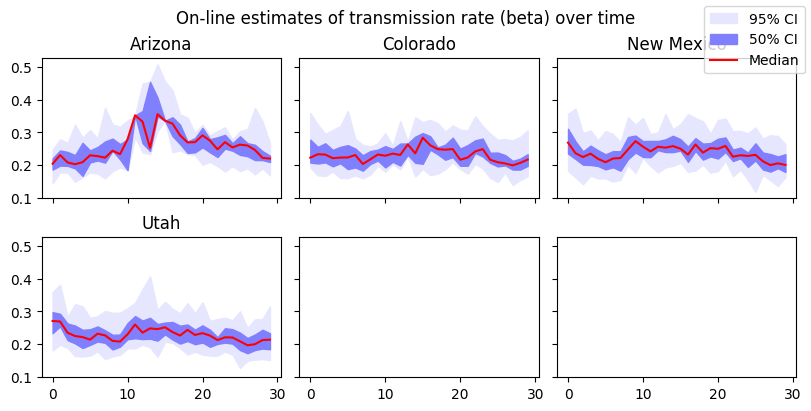

In [7]:
ncols = 3
nrows = int(np.ceil((my_rume.scope.nodes + 1) / ncols))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
fig.set_layout_engine("compressed")
fig.set_figwidth(8)
fig.set_figheight(8 * nrows / 4)
axs = np.ravel(np.array(axs))
for node in range(my_rume.scope.nodes):
    quantiles_values = np.quantile(
        np.exp(estimated_params[NamePattern.of("log_beta")][:, :, node]),
        [0.025, 0.25, 0.50, 0.75, 0.975],
        axis=1,
    )

    t = np.arange(quantiles_values.shape[1])
    axs[node].fill_between(
        t,
        quantiles_values[0, ...],
        quantiles_values[4, ...],
        color=[0.9, 0.9, 1],
    )
    axs[node].fill_between(
        t,
        quantiles_values[1, ...],
        quantiles_values[3, ...],
        color=[0.5, 0.5, 1],
    )
    axs[node].plot(
        t,
        quantiles_values[2, ...],
        color="red",
    )

    axs[node].set_title(my_rume.scope.get_info()["NAME"][node])

fig.legend(["95% CI", "50% CI", "Median"])

plt.suptitle("On-line estimates of transmission rate (beta) over time")
plt.show()

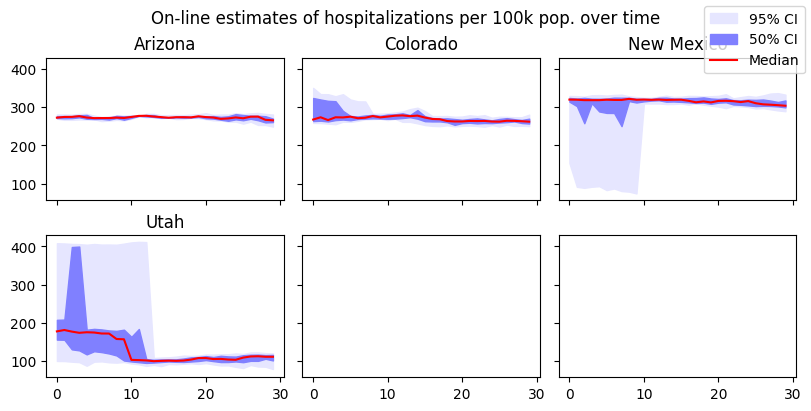

In [8]:
if "hospitalization_prob" in my_unknown_params.keys():
    ncols = 3
    nrows = int(np.ceil((my_rume.scope.nodes + 1) / ncols))

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    fig.set_layout_engine("compressed")
    fig.set_figwidth(8)
    fig.set_figheight(8 * nrows / 4)
    axs = np.ravel(np.array(axs))
    for node in range(my_rume.scope.nodes):
        quantiles_values = np.quantile(
            100_000
            * estimated_params[NamePattern.of("hospitalization_prob")][:, :, node],
            [0.025, 0.25, 0.50, 0.75, 0.975],
            axis=1,
        )

        t = np.arange(quantiles_values.shape[1])
        axs[node].fill_between(
            t,
            quantiles_values[0, ...],
            quantiles_values[4, ...],
            color=[0.9, 0.9, 1],
        )
        axs[node].fill_between(
            t,
            quantiles_values[1, ...],
            quantiles_values[3, ...],
            color=[0.5, 0.5, 1],
        )
        axs[node].plot(
            t,
            quantiles_values[2, ...],
            color="red",
        )

        axs[node].set_title(my_rume.scope.get_info()["NAME"][node])

    fig.legend(["95% CI", "50% CI", "Median"])

    plt.suptitle("On-line estimates of hospitalizations per 100k pop. over time")
    plt.show()

In [9]:
# # Example of plotting individual particles for a parameter.
# plt.plot((100_000*estimated_params[NamePattern.of("hospitalization_prob")][:, :, 3]).T)